# Cross-validation of Github data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import deep4cast.models as models
import deep4cast.cv as cv

from deep4cast.forecasters import Forecaster
from deep4cast.cv import FoldGenerator, VectorScaler, MetricsEvaluator, CrossValidator
from skopt.space import Real, Integer, Categorical

%matplotlib inline

Using TensorFlow backend.
/Users/toby/anaconda3/envs/deep_forecast/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.23) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# Parameters

In [8]:
horizon = 90
lag = 180
filters=32
num_layers=2
lr=0.001
epochs=500
test_fraction = 0.15
n_folds=1

# Load the data from file
df = pd.read_pickle('../data/processed/github_total_push_events_2011-2018.pkl')
df = df[:-243] # Exclude 2018

# Data exploration

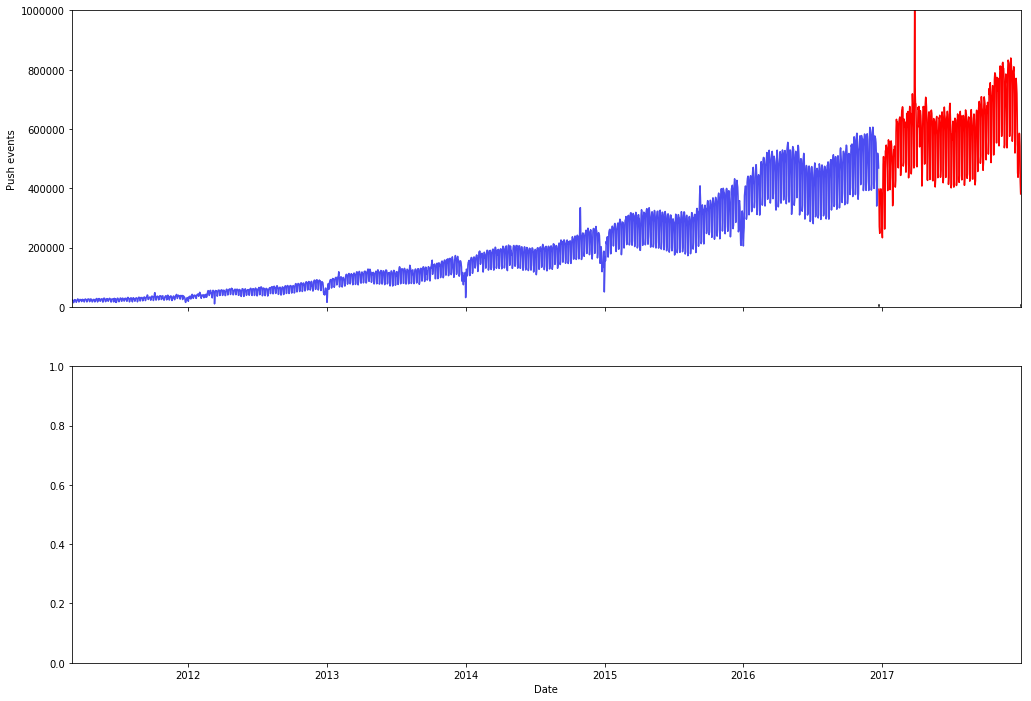

Training fraction: 0.85
Testing fraction: 0.15
Training data points: 2121
Testing data points: 374


<Figure size 432x288 with 0 Axes>

In [9]:
# Let plot the target time series data folds that will be used for temporal cross-validation
test_length = int(len(df)*test_fraction)
train_length = len(df) - n_folds*test_length

fig, axes = plt.subplots(nrows=n_folds+1, ncols=1, sharex=True, figsize=(17, 12))
for ax, i in zip(axes.flat, range(n_folds)):
    x_train = df.date[i*test_length:i*test_length+train_length]
    y_train = df['count'][i*test_length:i*test_length+train_length]
    x_test = df.date[i*test_length+train_length:(i+1)*test_length+train_length]
    y_test = df['count'][i*test_length+train_length:(i+1)*test_length+train_length]
    x_all = df.date
    y_all = df['count']
    ax.plot(x_all, y_all, 'k-', alpha=0.15)
    ax.plot(x_train, y_train, 'b-', alpha=0.65)
    ax.plot(x_test, y_test, 'r-')
    ax.plot([min(x_test), min(x_test)], [2000, 5500], 'k-')
    ax.plot([max(x_test), max(x_test)], [2000, 5500], 'k-')
    ax.set_ylim([0, 1e6])
    ax.set_xlim([min(x_all), max(x_all)])
    ax.set_ylabel('Push events')
plt.xlabel('Date')
plt.show()
plt.tight_layout()

# Print the number of training, validation, and testing time steps
print(
    'Training fraction: {}\nTesting fraction: {}\nTraining data points: {}\nTesting data points: {}'.format(
    round((1-n_folds*test_fraction), 3), 
    round(test_fraction, 3),
    int(len(df)*(1-n_folds*test_fraction)), 
    int(len(df)*test_fraction)
))

# Data preparation

In [10]:
# Loading the dataset and dropping unncecessary columns
data = df.drop(['date', 'month', 'day'], axis=1)
data = data.dropna()

# We have real-valued and categorial features and we need to make sure that we do the data 
# preparation for them correctly
real_values = ['count', 'age']
categorical = list(set(data.columns).difference(set(real_values)))

# Let's create shifted categorical feature to include information about the future's holiday 
# structure. This will make it easier for our model to do predictions on holidays
shifted = data[categorical].shift(-horizon)
data[categorical] = shifted

# Let's also put lagged covariates
lagged = data[['count']].shift(365-horizon)
lagged = lagged.rename(columns={column:column + '_annual_lag' for column in lagged.columns})
data = pd.concat([data, lagged], axis=1)
data = data.dropna()

# Format data into numpy array
data = np.expand_dims(data.values, 0)

# Model

In [11]:
# forecaster and model setup
model = models.WaveNet(filters=filters, num_layers=num_layers)
forecaster = Forecaster(model, lag=lag, horizon=horizon, lr=lr, epochs=epochs)

# build a fold generator
fold_generator = FoldGenerator(
    data=data, 
    targets=[0], 
    lag=lag, 
    horizon=horizon, 
    test_fraction=test_fraction, 
    n_folds=n_folds
)

# ... and an evaluator
evaluator = MetricsEvaluator(metrics = ['smape', 'pinball_loss', 'coverage'])

# ... and a data scaler
scaler = VectorScaler(targets = [0, 1, -1])

# ... and a cross-validator
validator = CrossValidator(forecaster, fold_generator, evaluator, scaler)

# Cross Validation

In [6]:
# Evaluate on the cross-validation folds
metrics = validator.evaluate(verbose=True)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Results for smape is 17.36.
Results for pinball_loss is 3532652.05.
Results for coverage is ([0.0, 0.26570048309178745, 27.850241545893724, 70.1304347826087, 99.56038647342996, 99.9903381642512, 100.0], [1, 5, 25, 50, 75, 95, 99]).
Evaluation took 52.65735983848572 seconds.


# Evaluation

   smape  pinball_loss                                           coverage
0  17.36    3532652.05  ([0.0, 0.26570048309178745, 27.850241545893724...


Text(0,0.5,'Prediction quantile')

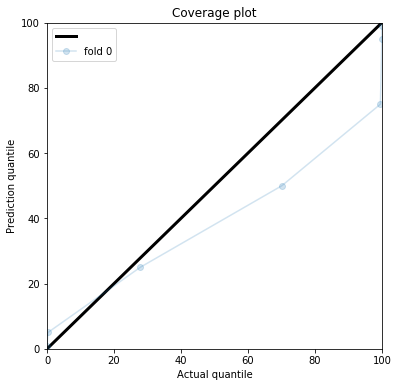

In [7]:
# Let's look at the cross-validation results
print(metrics)

# Plot probability calibration plots
x = [1, 5, 25, 50, 75, 95, 99]
coverages = metrics.iloc[:-2,-7:]
plt.figure(figsize=(6, 6))
plt.plot([0] + x + [100], [0] + x + [100], 'k-', linewidth=3)
for cov_x, cov_y in metrics.coverage:
    plt.plot(cov_x, cov_y, 'o-', alpha=0.2)
plt.legend([''] + ['fold ' + str(s) for s in np.arange(n_folds)])
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.title('Coverage plot')
plt.xlabel('Actual quantile')
plt.ylabel('Prediction quantile')

# Optimization

In [ ]:
space  = [Categorical([32, 64, 128, 256, 512], name='filters'),
          Integer(1, 4, name='num_layers'),
          Integer(90, 730, name='lag'),
          Real(10**-5, 10**-3, "log-uniform", name='lr')]

opt_results = validator.optimize(space, 'pinball_loss', n_calls=50)